# LSTM RNN

This is an implementation of the LSTM RNN from Bowman et al. (https://nlp.stanford.edu/pubs/snli_paper.pdf) for text classification on the SST dataset and Textual entailment on the SNLI dataset. 

## Initialzation

Required packages and helper functions.

In [4]:
import numpy as np

from torchtext import data
from torchtext import datasets
from torchtext.vocab import Vectors

import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.optim as optim
from torch.nn import Linear
from torch.nn.functional import softmax, relu, tanh
from torchtext.vocab import Vectors, GloVe, CharNGram, FastText
from torch.nn.utils.rnn import pack_padded_sequence as pack
from torch.nn.utils.rnn import pad_packed_sequence as unpack
from torch.nn.utils.rnn import pad_sequence as pad

import matplotlib.pyplot as plt

from sklearn.manifold import TSNE

from bokeh.plotting import figure, ColumnDataSource
from bokeh.models import HoverTool
from bokeh.io import output_notebook, show, push_notebook

output_notebook()

Loading BokehJS ...

In [5]:
use_cuda = torch.cuda.is_available()

def get_variable(x):
    """ Converts tensors to cuda, if available. """
    if use_cuda:
        return x.cuda()
    return x

def get_numpy(x):
    """ Get numpy array for both cuda and not. """
    if use_cuda:
        return x.cpu().data.numpy()
    return x.data.numpy()

In [6]:
def construct_sentences(batch):
    """    
    Parameters
    ----------
    batch: torchtext.data.batch.Batch
    
    Returns
    -------
    [str]
    """
    return [" ".join([TEXT.vocab.itos[elm] 
                      for elm in get_numpy(batch.text[:,i])])
            for i in range(batch.text.size()[1])]

def get_labels(batch):
    """
    Parameters
    ----------
    batch: torchtext.data.batch.Batch
    
    Returns
    -------
    [str]
    """
    return [LABEL.vocab.itos[get_numpy(batch.label[i])] for i in range(len(batch.label))]

def accuracy(ys, ts):
    correct_prediction = torch.eq(torch.max(ys, 1)[1], ts)
    return torch.mean(correct_prediction.float())

## SST
### Data creation

In [12]:
TEXT = data.Field(sequential=True, include_lengths = True)
LABEL = data.Field(sequential=False)

train_set, validation_set, test_set = datasets.SST.splits(TEXT,
                                                          LABEL,
                                                          fine_grained=False,
                                                          train_subtrees=True,
                                                          filter_pred=lambda ex: ex.label != 'neutral')

In [13]:
# build the vocabulary
url = 'https://s3-us-west-1.amazonaws.com/fasttext-vectors/wiki.simple.vec'
TEXT.build_vocab(train_set, max_size=None, vectors=Vectors('wiki.simple.vec', url=url))
#TEXT.build_vocab(train_set,vectors=GloVe(name='840B',dim='300'))
LABEL.build_vocab(train_set)
# print vocab information
print('len(TEXT.vocab)', len(TEXT.vocab))
print('TEXT.vocab.vectors.size()', TEXT.vocab.vectors.size())

# make iterator for splits
train_iter, val_iter, test_iter = data.Iterator.splits(
    (train_set, validation_set, test_set), batch_size=32, sort_key=lambda x: len(x.text),sort_within_batch=True)
batchsst = next(iter(train_iter))

len(TEXT.vocab) 18005
TEXT.vocab.vectors.size() torch.Size([18005, 300])


### Model framework

In [14]:
embedding_dim = TEXT.vocab.vectors.size()[1]
num_embeddings = TEXT.vocab.vectors.size()[0]
num_classes = len(LABEL.vocab.itos)

dropout_rate = 0.4
input_dim = 200
con_dim = 200
hid_size = 500

# build the LSTM model
class LSTMNet(nn.Module):

    def __init__(self):
        super(LSTMNet, self).__init__()
        self.embeddings = nn.Embedding(num_embeddings, embedding_dim)
        # use pretrained embeddings
        self.embeddings.weight.data.copy_(TEXT.vocab.vectors)

        # Simple RNN LSTM Layer
        self.lstm_input = nn.LSTM(input_size = embedding_dim,
                                  hidden_size = hid_size)
        
        # Linear layer (with tanh activation) for mapping to lower dimensions
        self.input = Linear(in_features = hid_size,
                             out_features = input_dim,
                             bias = True)
        
        # Three stacked linear layers (with tanh activation)
        self.l_1 = Linear(in_features=input_dim,
                           out_features=con_dim,
                           bias = True)
        self.l_2 = Linear(in_features=con_dim,
                           out_features=con_dim,
                           bias=True)
        self.l_3 = Linear(in_features=con_dim,
                           out_features = con_dim,
                           bias = True)
        self.batchnorm = nn.BatchNorm1d(num_features=con_dim)
        
        
        # Applied dropout
        self.drop = nn.Dropout(p = dropout_rate)
        
        # Putput layer
        self.l_out = Linear(in_features= con_dim,
                            out_features=num_classes,
                            bias=False)
        
        
    def forward(self, x):
        out = {}
        
        # input = (text_tensor, seq_length_tensor)
        x_text = x[0] #Text of input
       # y_text = y[0]
        x_len = x[1] #Sequence length of input
       # y_len = y[1]
    
        x_len, idx_sort = np.sort(x_len)[::-1],np.argsort(-x_len)
        x_text = x_text.index_select(1,torch.LongTensor(idx_sort))
    
        #x_text = self.drop(x_text)
        # Get embeddings
        x = self.embeddings(x_text) # (batch size, length, embedding dim)
       # y = self.embeddings(y_text)
        x = self.drop(x)
        
        # Applied dropout
       # x = self.drop(x)
       # y = self.drop(y)

        # Packing padded sequences to max_length
        packed_x = pack(x,x_len, batch_first = False)
       # packed_y = pack(y,y_len.view(-1).tolist(), batch_first = False)
       # packed_x = self.drop(packed_x)
        
        # LSTM RNN Layer
        x = self.lstm_input(packed_x)[1][0].squeeze(0)
       # y, ht_y0 = self.lstm_input(packed_y)
        
       # x = self.drop(x)
        
        # Unpacking packed tensors
       #unpacked_x, unpacked_len = unpack(x, batch_first = False)
       # unpacked_y, unpacked_len = unpack(y, batch_first = False)
        xt = x
       # xt = torch.squeeze(xt,0)
       # print(xt.size())
        
       # xt = self.drop(xt)
       # yt = unpacked_y
        
        idx_unsort = np.argsort(idx_sort)
        xt = xt.index_select(0,torch.LongTensor(idx_unsort))
        
        xt = self.drop(xt)
        
     #   xt = torch.cat((torch.mean(xt,dim=0),torch.max(xt,dim=0)[0]),dim=1)
        #print(xt.size())
        
        
        # Mapping input from 300 dim to 100 dim and concatenating
        xt = tanh(self.input(xt))
      #  yt = torch.tanh(self.input(yt))
        
        z = xt
        
        #
        # Three stacked tanh layers
        z = tanh(self.l_1(z))     
        z = tanh(self.l_2(z))
        z = tanh(self.l_3(z))
        
        z = self.batchnorm(z)
 
        # Softmax
        out['out'] = softmax(self.l_out(z))
        return out

net = LSTMNet()
print(net)

LSTMNet(
  (embeddings): Embedding(18005, 300)
  (lstm_input): LSTM(300, 500)
  (input): Linear(in_features=500, out_features=200, bias=True)
  (l_1): Linear(in_features=200, out_features=200, bias=True)
  (l_2): Linear(in_features=200, out_features=200, bias=True)
  (l_3): Linear(in_features=200, out_features=200, bias=True)
  (batchnorm): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (drop): Dropout(p=0.4)
  (l_out): Linear(in_features=200, out_features=3, bias=False)
)


In [15]:
#{p[0]: p[1].requires_grad for p in net.named_parameters()}


### Training the model

In [49]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(),lr=0.001,amsgrad=True,weight_decay=0.00001)

#max_iter = 100
eval_every = 1000
log_every = 200
#epochmax = 5


train_loss, train_accs, train_iter_list = [], [], []
train_loss_list, train_accs_list = [],[]
val_loss_list, val_accs_list, val_iter_list = [],[], []


max_acc = 0
max_acc_idx = 0
epochs = 1
reached_max = False

net.train()
while reached_max == False:
    print("EPOCH NR: " + str(epochs))
    for i, batch in enumerate(train_iter):
        if i % eval_every == 0:
            net.eval()
            val_losses, val_accs, val_lengths = 0, 0, 0
      #  val_meta = {'label_idx': [], 'sentences': [], 'labels': []}
            for val_batch in val_iter:
                output = net(val_batch.text)
            # batches sizes might vary, which is why we cannot just mean the batch's loss
            # we multiply the loss and accuracies with the batch's size,
            # to later divide by the total size
                val_losses += criterion(output['out'], val_batch.label) * val_batch.batch_size
                val_accs += accuracy(output['out'], val_batch.label) * val_batch.batch_size
                val_lengths += val_batch.batch_size
            

        
        # divide by the total accumulated batch sizes
            val_losses /= val_lengths
            val_accs /= val_lengths
        
            val_loss_list.append(get_numpy(val_losses))
            val_accs_list.append(get_numpy(val_accs))
            val_iter_list.append(i)
        
            print("valid, it: {} loss: {:.2f} accs: {:.2f}\n".format(i, get_numpy(val_losses), get_numpy(val_accs)))
        #update_plot(val_meta, 'bow', tsne_plot)
        
            net.train()
    
        output = net(batch.text)
        batch_loss = criterion(output['out'], batch.label)
    
        train_loss.append(get_numpy(batch_loss))
        train_accs.append(get_numpy(accuracy(output['out'], batch.label)))
 
    
        optimizer.zero_grad()
        batch_loss.backward()
        nn.utils.clip_grad_norm_(net.parameters(),max_norm=0.5)
        optimizer.step()
    
        if i % log_every == 0:        
            print("train, it: {} loss: {:.2f} accs: {:.2f}".format(i, 
                                                               np.mean(train_loss), 
                                                               np.mean(train_accs)))
        # reset
            train_loss_list.append(np.mean(train_loss))
            train_accs_list.append(np.mean(train_accs))    
            train_iter_list.append(i)
            train_loss, train_accs = [], []
    if max(val_accs_list[max_acc_idx:len(val_accs_list)]) > max_acc:
        max_acc = max(val_accs_list[max_acc_idx:len(val_accs_list)])
        max_acc_idx = np.argmax(max(val_accs_list[max_acc_idx:len(val_accs_list)]))
    else:
        print("Maximum validation accuracy: " + str(max_acc))
        reached_max = True
        break
    epochs += 1

EPOCH NR: 1


C:\Users\Frederik\Anaconda3\lib\site-packages\torch\nn\functional.py:995: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
C:\Users\Frederik\Anaconda3\lib\site-packages\ipykernel_launcher.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


valid, it: 0 loss: 0.87 accs: 0.68

train, it: 0 loss: 0.68 accs: 0.88
valid, it: 50 loss: 0.92 accs: 0.63

train, it: 50 loss: 0.83 accs: 0.72
valid, it: 100 loss: 0.92 accs: 0.62

train, it: 100 loss: 0.85 accs: 0.69
EPOCH NR: 2
valid, it: 0 loss: 0.91 accs: 0.63

train, it: 0 loss: 0.83 accs: 0.69
valid, it: 50 loss: 0.90 accs: 0.64

train, it: 50 loss: 0.84 accs: 0.71
valid, it: 100 loss: 0.87 accs: 0.68

train, it: 100 loss: 0.81 accs: 0.73
EPOCH NR: 3
valid, it: 0 loss: 0.88 accs: 0.67

train, it: 0 loss: 0.69 accs: 0.88
valid, it: 50 loss: 0.86 accs: 0.69

train, it: 50 loss: 0.81 accs: 0.74
valid, it: 100 loss: 0.88 accs: 0.66

train, it: 100 loss: 0.81 accs: 0.74
EPOCH NR: 4
valid, it: 0 loss: 0.89 accs: 0.66

train, it: 0 loss: 0.68 accs: 0.91
valid, it: 50 loss: 0.84 accs: 0.71

train, it: 50 loss: 0.78 accs: 0.76
valid, it: 100 loss: 0.84 accs: 0.71

train, it: 100 loss: 0.79 accs: 0.75
EPOCH NR: 5
valid, it: 0 loss: 0.84 accs: 0.70

train, it: 0 loss: 0.66 accs: 0.88
valid

In [51]:
print(epoch_iter_train)
print(epoch_iter_val)
print(len(train_iter_list)/(epochs))
print(len(val_iter_list)/(epochs))
print(epochs)
#herp = train_iter_list
#print(herp)

[0, 50, 100, 0, 100, 200, 0, 150, 300, 0, 200, 400, 0, 250, 500]
[0, 50, 100, 0, 100, 200, 0, 150, 300, 0, 200, 400, 0, 250, 500]
3.0
3.0
5


In [52]:
for i in range(int(len(train_iter_list)/(epochs)),len(train_iter_list)):
    if train_iter_list[i] == 0:
        train_iter_list[i] = train_iter_list[i-1]+1
    else:
        train_iter_list[i] = train_iter_list[i-int(len(train_iter_list)/epochs)+1] + train_iter_list[i]


for i in range(int(len(val_iter_list)/epochs),len(val_iter_list)):
    if val_iter_list[i] == 0:
        val_iter_list[i] =val_iter_list[i-1]+1
    else:
        val_iter_list[i] = val_iter_list[i] + val_iter_list[i-int(len(train_iter_list)/epochs)+1]

[0, 50, 100, 101, 150, 201, 202, 251, 302, 303, 352, 403, 404, 453, 504]
[0, 50, 100, 101, 150, 201, 202, 251, 302, 303, 352, 403, 404, 453, 504]


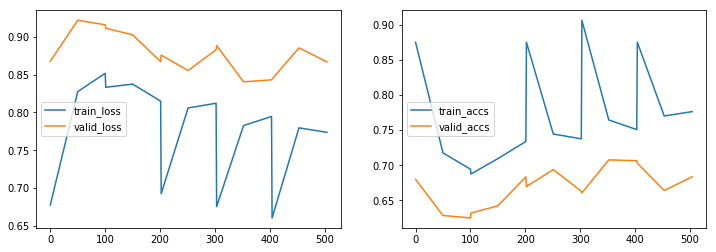

In [53]:
fig = plt.figure(figsize=(12,4))
plt.subplot(1, 2, 1)
plt.plot(train_iter_list, train_loss_list, label='train_loss')
plt.plot(val_iter_list, val_loss_list, label='valid_loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_iter_list, train_accs_list, label='train_accs')
plt.plot(val_iter_list, val_accs_list, label='valid_accs')
plt.legend()
plt.show()

# SNLI

In [ ]:
print("Run test on SNLI...")
TEXT = datasets.nli.ParsedTextField()
LABEL = data.Field(sequential=False)
TREE = datasets.nli.ShiftReduceField()

train, validation, test = datasets.SNLI.splits(TEXT, LABEL,TREE)

print("Fields:", train.fields)
print("Number of examples:\n", len(train))
print("First Example instance:\n", vars(train[0]))

url = 'https://s3-us-west-1.amazonaws.com/fasttext-vectors/wiki.simple.vec'
#TEXT.build_vocab(train, max_size=None, vectors=Vectors('wiki.simple.vec', url=url))
TEXT.build_vocab(train,vectors=GloVe(name='840B',dim='300'))
LABEL.build_vocab(train)

batchsize = 64

train_iter, val_iter, test_iter = data.Iterator.splits(
    (train, validation, test), batch_size=batchsize, repeat=False)
# sort_key=lambda x:len(x.premise),sort_within_batch=True, 
#batch = next(iter(train_iter))
#print("Numericalize premises:\n", batch.premise)
#print("Numericalize hypotheses:\n", batch.hypothesis)
#print("Entailment labels:\n", batch.label)

print("Test iters function")
#train_iter, val_iter, test_iter = datasets.SNLI.iters(batch_size=4, trees=True)

batch = next(iter(train_iter))
print("Numericalize premises:\n", batch.premise)
print("Numericalize hypotheses:\n", batch.hypothesis)
print("Entailment labels:\n", batch.label)

#use_cuda = torch.cuda.is_available()

In [ ]:
embedding_dim = TEXT.vocab.vectors.size()[1]
num_embeddings = TEXT.vocab.vectors.size()[0]
num_classes = len(LABEL.vocab.itos)

dropout_rate = 0.4
input_dim = 100
con_dim = 200


# build the LSTM model
class LSTMNet(nn.Module):

    def __init__(self):
        super(LSTMNet, self).__init__()
        self.embeddings = nn.Embedding(num_embeddings, embedding_dim)
        # use pretrained embeddings
        self.embeddings.weight.data.copy_(TEXT.vocab.vectors)

        # Simple RNN LSTM Layer
        self.lstm_input = nn.LSTM(input_size = embedding_dim,
                                  hidden_size = embedding_dim,
                                  num_layers = 1,
                                  batch_first = False)
        
        # Linear layer (with tanh activation) for mapping to lower dimensions
        self.input = Linear(in_features = embedding_dim,
                             out_features = input_dim,
                             bias = False)
        
        # Three stacked linear layers (with tanh activation)
        self.l_1 = Linear(in_features=con_dim,
                           out_features=con_dim,
                           bias = False)
        self.l_2 = Linear(in_features=con_dim,
                           out_features=con_dim,
                           bias=False)
        self.l_3 = Linear(in_features=con_dim,
                           out_features = con_dim,
                           bias = False)
        
        
        # Applied dropout
        self.drop = nn.Dropout(p = dropout_rate)
        
        # Putput layer
        self.l_out = Linear(in_features=con_dim,
                            out_features=num_classes,
                            bias=False)
        
        
    def forward(self, x, y):
        out = {}
        
        # First input
        # input = (text_tensor, seq_length_tensor)
        x_text, x_len = x
        
        # Sorting tensors
        x_len, idx_sort = np.sort(x_len)[::-1],np.argsort(-x_len)
        x_text = x_text.index_select(1,torch.LongTensor(idx_sort))

        # Get embeddings
        x = self.embeddings(x_text) # (batch size, length, embedding dim)
        
        # Applied dropout
        x = self.drop(x)

        # Packing padded sequences to max_length
        packed_x = pack(x,x_len.copy(), batch_first = False)
        
        # LSTM RNN Layer
        x = self.lstm_input(packed_x)[1][0].squeeze(0)
        xt = x
        
        # Unsorting
        idx_unsort = np.argsort(idx_sort)
        xt = xt.index_select(0,torch.LongTensor(idx_unsort))
                
        # Second input
        # input = (text_tensor, seq_length_tensor)
        y_text, y_len  = y
        
        # Sorting tensors
        y_len, idx_sort = np.sort(y_len)[::-1],np.argsort(-y_len)
        y_text = y_text.index_select(1,torch.LongTensor(idx_sort))

        # Get embeddings
        y = self.embeddings(y_text) # (batch size, length, embedding dim)
        
        # Applied dropout
        y = self.drop(y)

        # Packing padded sequences to max_length
        packed_y = pack(y,y_len.copy(), batch_first = False)
        
        # LSTM RNN Layer
        y = self.lstm_input(packed_y)[1][0].squeeze(0)
        yt = y
        
        # Unsorting
        idx_unsort = np.argsort(idx_sort)
        yt = yt.index_select(0,torch.LongTensor(idx_unsort))
        
        # Mapping input from 300 dim to 100 dim and concatenating
        xt = torch.tanh(self.input(xt)) #(4,3,100)
        yt = torch.tanh(self.input(yt)) #(6,3,100)
        z = torch.cat((xt,yt),1)
        
        # Three stacked tanh layers
        z = torch.tanh(self.l_1(z))     
        z = torch.tanh(self.l_2(z))
        z = torch.tanh(self.l_3(z))
 
        # Softmax
        out['out'] = softmax(self.l_out(z), 1)
        return out

net = LSTMNet()
print(net)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001,amsgrad=True,weight_decay=0.00001)

def accuracy(ys, ts):
    # making a one-hot encoded vector of correct (1) and incorrect (0) predictions
    correct_prediction = torch.eq(torch.max(ys, 1)[1], ts)
    # averaging the one-hot encoded vector
    return torch.mean(correct_prediction.float())

In [ ]:

max_iter = 1
eval_every = 500
log_every = 200

# will be updated while iterating
#tsne_plot = show(p, notebook_handle=True)

train_loss, train_accs = [], []

net.train()
for i, batch in enumerate(train_iter):
    if i % eval_every == 0:
        net.eval()
        val_losses, val_accs, val_lengths = 0, 0, 0
       # val_meta = {'label_idx': [], 'sentences': [], 'labels': []}
        for val_batch in val_iter:
            output = net(val_batch.premise,val_batch.hypothesis)
            # batches sizes might vary, which is why we cannot just mean the batch's loss
            # we multiply the loss and accuracies with the batch's size,
            # to later divide by the total size
            #print(output['out'])
            #print(val_batch.label)
            val_losses += criterion(output['out'], val_batch.label) * val_batch.batch_size
            val_accs += accuracy(output['out'], val_batch.label) * val_batch.batch_size
            val_lengths += val_batch.batch_size
           # print(val_batch.batch_size)
            
        
        # divide by the total accumulated batch sizes
        val_losses /= val_lengths
        val_accs /= val_lengths
        
        print("valid, it: {} loss: {:.2f} accs: {:.2f}\n".format(i, get_numpy(val_losses), get_numpy(val_accs)))
        #update_plot(val_meta, 'bow', tsne_plot)
        
        net.train()
    
    output = net(batch.premise,batch.hypothesis)
    batch_loss = criterion(output['out'], batch.label)
    
    train_loss.append(get_numpy(batch_loss))
    train_accs.append(get_numpy(accuracy(output['out'], batch.label)))
    
    optimizer.zero_grad()
    batch_loss.backward()
    nn.utils.clip_grad_norm_(net.parameters(),max_norm=0.5)
    optimizer.step()
    
    if i % log_every == 0:        
        print("train, it: {} loss: {:.2f} accs: {:.2f}".format(i, 
                                                               np.mean(train_loss), 
                                                               np.mean(train_accs)))
        # reset
        train_loss, train_accs = [], []